### Nuißl Sandra, 14.08.2023
## "Empirische Evaluation von ‚State Of The Art‘ Topic Modeling Ansätze am Beispiel von Produktreviews für die Entscheidungsunterstützung in Unternehmen"
### - Implementierung und Evaluierung der Topic Modelling Modelle: LDA -

<hr>

## **Inhaltsverzeichnis**

<ul>1. Aufbau des Jupyter Notebooks</ul>
<ul>2. Instalation und Imports</ul>
    <ul>
     <ul>2.1. Installationen</ul>
     <ul>2.2. Imports</ul>
    </ul>
<ul>3. Laden der bereinigten Amazon Daten</ul>
<ul>4. Implementierung des Modells</ul>
    <ul>
     <ul>4.1. Tokenisierung und Vectorisierung</ul>
     <ul>4.2. Modellierung</ul>
     <ul>4.3. Visualisierung</ul>
    </ul>
<ul>5. Evaluierung</ul>
    <ul>
     <ul>5.1. Coherence score</ul>
     <ul>5.2. Perplexity</ul>
     <ul>5.3. Similarity</ul>
    </ul>
<ul>6. Literaturverzeichnis</ul>
<hr>

## 1. Aufbau des Jupyter Notebooks
Dieses Jupyter Notebook ist Teil der Master Thesis "Empirische Evaluation von ‚State Of The Art‘ Topic Modeling Ansätze am Beispiel von Produktreviews für die Entscheidungsunterstützung in Unternehmen".
Es beinhaltet die Implementierung des Topic Modelling Modells von __LDA__ sowie dessen Evaluierung.

Die theoretischen Inhalte zu diesem Notebook sind der schriftlichen Ausarbeitung dieser Masterarbeit unter den Kapiteln "5. 2.	LDA" und "6.	Empirische Evaluierung der Modelle" zu entnehmen.

## 2. Instalationen und Imports
### 2.1. Installationen

In [ ]:
# Instalationen
%pip install nltk
%pip install tables
%pip install pyLDAvis
%pip install gitly==1.0.1
%pip install plotly>4.0.0

### 2.2. Imports

In [ ]:
# Imports und Initalisierungen
import numpy as np
import pandas as pd
import tables
import re
import warnings
warnings.filterwarnings('ignore')

# Beschleunigung
import joblib
from joblib import Parallel, delayed

# Progressbar
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
from tqdm.auto import tqdm
tqdm_notebook.pandas()

# Datenvisualisierung
import plotly.express as px
from gitly.colab.plot import GitlyPlotter
gitly = GitlyPlotter('github')                   # Instanziierung des Objekts

# Modelling
import gensim
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
from pprint import pprint

# Evaluierung
from gensim.models import CoherenceModel
from sklearn.metrics.pairwise import cosine_similarity

There are few libs and modules that should be installed in Colab in order to generate static plots from Plotly.
Summary: Install Orca, update plotly and update apt-get

apt-get update
pip install plotly>=4.0.0
wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
chmod +x /usr/local/bin/orca
apt-get install xvfb libgtk2.0-0 libgconf-2-4
Done. Have fun! :)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 3. Laden der bereinigten Amazon Daten

In [ ]:
# Review Daten laden
reviews_df = pd.read_hdf('Cleaned_Sport_and_Outdoors.h5')

# Ausgabe
pd.concat([reviews_df], axis=1, sort = False, keys = ["Bereinigter Datensatz: Sport and Outdoors"])

Bereinigter Datensatz: Sport and Outdoors  \
                                                reviewText   
0                  What a spectacular tutu! Very slimming.   
1        What the heck? Is this a tutu for nuns? I know...   
2                        Exactly what we were looking for!   
3        I used this skirt for a Halloween costume and ...   
4        This is thick enough that you can't see throug...   
...                                                    ...   
2264636                     Wife laughs at me but it works   
2264637  2XU makes great compression shorts. A bit more...   
2264638  These are my favorite compression shorts for r...   
2264639  Love the shorts.. amazing comfortable, perfect...   
2264640  I have a briley bolt release paddle installed ...   

                                                                          \
                                               cleanedText  year overall   
0                               spectacular tutu veri slim  2015     5.0   
1        heck tutu nun know cut still also nt sever lay...  2015     1.0   
2                                               exact look  2015     5.0   
3        use skirt halloween costum glue bunch feather ...  2014     5.0   
4        thick enough ca nt see veri long sure check di...  2014     4.0   
...                                                    ...   ...     ...   
2264636                                    wife laugh work  2018     4.0   
2264637  xu make great compress short bit expens well w...  2018     5.0   
2264638  favorit compress short run thinnest materi run...  2018     5.0   
2264639  love short amaz comfort perfect compress perfe...  2018     5.0   
2264640  briley bolt releas paddl instal a xplor sport ...  2017     5.0   

                                                                      \
            brand                                              title   
0        BubuBibi                           Adult Ballet Tutu Yellow   
1        BubuBibi                           Adult Ballet Tutu Yellow   
2        BubuBibi                           Adult Ballet Tutu Yellow   
3        BubuBibi                           Adult Ballet Tutu Yellow   
4        BubuBibi                           Adult Ballet Tutu Yellow   
...           ...                                                ...   
2264636  Columbia                               Columbia Bora booney   
2264637       2XU                  2XU Men's Core Compression Shorts   
2264638       2XU                  2XU Men's Core Compression Shorts   
2264639       2XU                  2XU Men's Core Compression Shorts   
2264640       STS  T&amp;s Shell Catcher Beretta A400 Multitarget...   

                     
               asin  
0        0000032034  
1        0000032034  
2        0000032034  
3        0000032034  
4        0000032034  
...             ...  
2264636  B01HJDZ34I  
2264637  B01HJGAJ9O  
2264638  B01HJGAJ9O  
2264639  B01HJGAJ9O  
2264640  B01HJHHBHG  

[2264641 rows x 7 columns]

#### __Verleinerung des Datensatzes__
LDA ist in der Lage größere Datenmengen zu verarbeiten. Da aber aus Kapazitätsgründen der Datensatz für andere Modelle verkeleinert werden musste, wird für alle Topic Modelling Modelle der gleiche Datensatz verwendet. Dadurch können die Ergebnisse der Evaluierung besser verglichen werden.

In [ ]:
# Verleinerung des Datensatzes Aufgrund der Performence
reviews_df = reviews_df.iloc[ :100000,]

## 4. Implementierung des Modells

### 4.1. Tokenisierung und Vectorisierung

Für diese Implementierung von LDA wird die Tokenisierung von der Vektorisierung getrennt. Gensim bietet hierfür eine kurze Preprocessing Pipeline, welche auch den Split in Token beinhaltet (Gensim-Dokumentation, 2016). Da jedoch die Bereinigung bereits unabhängig von den Modellen durchgeführt wurde, wird im Rahmen dieser Masterarbeit die Funktion „word_tokenize()“ von NLTK verwendet, um die Token zu erzeugen (Andrade, 2021). Nach der Tokenisierung folgt die Vektorisierung mithilfe des Bag-of-Word Ansatzes "doc2bow" (CR, 2020).

In [ ]:
# Definition einer Funktion zum Splitten der Texte in Token
def split_text(in_string):
  out_string = in_string.split()
  return out_string

In [ ]:
# Tokenisierung
# Quelle: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
reviews_df["Token"] = Parallel(n_jobs=-1)(delayed(split_text)(text) for text in tqdm(reviews_df["cleanedText"],
                                                                                     desc ="Status Tokenizierung: ",
                                                                                     total = len(reviews_df)))

# Speichern der Token in einer Liste
token_list = reviews_df.Token.to_list()

# Ausgabe
reviews_df.head(3)

Status Tokenizierung:   0%|          | 0/100000 [00:00<?, ?it/s]

,reviewText,cleanedText,year,overall,brand,title,asin,Token
0,What a spectacular tutu! Very slimming.,spectacular tutu veri slim,2015,5.0,BubuBibi,Adult Ballet Tutu Yellow,0000032034,"[spectacular, tutu, veri, slim]"
1,What the heck? Is this a tutu for nuns? I know...,heck tutu nun know cut still also nt sever lay...,2015,1.0,BubuBibi,Adult Ballet Tutu Yellow,0000032034,"[heck, tutu, nun, know, cut, still, also, nt, ..."
2,Exactly what we were looking for!,exact look,2015,5.0,BubuBibi,Adult Ballet Tutu Yellow,0000032034,"[exact, look]"


In [ ]:
# Vektorisierung
# Quelle: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

# Erstellung einers Dictionary
dictionary = corpora.Dictionary(token_list)

# Vectorisierung: Begriffs - Dokumenten - Häufigkeit (Korpus)
corpus = [dictionary.doc2bow(word) for word in tqdm(token_list, desc ="Status Vektorisierung: ", total = len(token_list))]

# Ausgabe des Korpus
print("Exemplarisch sind hier die ersten 5 Dokumente des Korpus aufgeführt: " , corpus[:5])

Status Vektorisierung:   0%|          | 0/100000 [00:00<?, ?it/s]

Exemplarisch sind hier die ersten 5 Dokumente des Korpus aufgeführt:  [[(0, 1), (1, 1), (2, 1), (3, 1)], [(2, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)], [(20, 1), (21, 1)], [(5, 1), (13, 2), (20, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1)], [(3, 1), (5, 1), (13, 1), (36, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1)]]


### 4.2. Modellierung
#### __Initialisierung des Modells__

Um die Verarbeitung der Daten zu beschleunigen wird die Klasse „LdaMulticore“ verwendet. Dieses Modell nutzt alle zur Verfügung stehenden CPU-Kerne und parallelisiert das Modelltraining durch Multiprocessing (Gensim-Dokumentation, 2023). Für die Implementierung werden die initialisierten Parameter eingesetzt und gewünschte Anzahl der Topics auf 10 gesetzt (Kapadia, 2019).

In [ ]:
# Erzeugen des LDA Topic Modelling Models (mit Beschleunigung)
# Quelle: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
lda_model = gensim.models.LdaMulticore(corpus = corpus,           # Wort-Dukumenten Matrix
                                       id2word = dictionary,      # Zuordnung der Wörter zu deren Wort - IDs
                                       num_topics = 10)           # Anzahl der latenten Themen, welche zu extrahieren sind

#### __Anwendung auf den Amazon Datensatz__

Als Output des Modells ergeben sich 10 verschiedene Topics, welche sich aus Schlüsselwörtern mit bestimmten Gewichtungsfaktoren zusammensetzen. Die Gewichtung drückt hierbei die Wichtigkeit der Begriffe für das Topic aus (Kapadia, 2019). Die Topics sind von 1 bis "num_topic" durchnummeriret und müssen durch den Anwender mit einem Schlüsselbegriff definiert werden.

In [ ]:
# Ausgabe der Keword pro Topic
pprint(lda_model.print_topics())

[(0,
  '0.024*"work" + 0.019*"great" + 0.019*"use" + 0.017*"good" + 0.015*"product" '
  '+ 0.012*"like" + 0.011*"need" + 0.011*"buy" + 0.010*"make" + 0.010*"well"'),
 (1,
  '0.017*"get" + 0.016*"nt" + 0.016*"use" + 0.010*"water" + 0.009*"camp" + '
  '0.007*"time" + 0.007*"like" + 0.007*"go" + 0.007*"keep" + 0.007*"take"'),
 (2,
  '0.041*"knife" + 0.016*"use" + 0.014*"blade" + 0.014*"nt" + 0.013*"one" + '
  '0.011*"veri" + 0.009*"sharp" + 0.009*"get" + 0.008*"great" + 0.008*"make"'),
 (3,
  '0.030*"great" + 0.017*"veri" + 0.017*"use" + 0.016*"one" + 0.016*"product" '
  '+ 0.012*"love" + 0.012*"buy" + 0.011*"purchas" + 0.010*"work" + '
  '0.009*"good"'),
 (4,
  '0.021*"great" + 0.021*"use" + 0.020*"get" + 0.019*"work" + 0.015*"ball" + '
  '0.014*"nt" + 0.011*"well" + 0.011*"one" + 0.007*"go" + 0.007*"would"'),
 (5,
  '0.032*"bike" + 0.014*"fit" + 0.013*"buy" + 0.012*"veri" + 0.010*"great" + '
  '0.010*"chain" + 0.009*"nt" + 0.009*"use" + 0.009*"seat" + 0.009*"perfect"'),
 (6,
  '0.026*"g

### 4.3.  Visualisierung
 Das interaktives Visualisierungstool zeigt die Ergebnisse der Topic Modelling Abalyse von LDA. Auf der linken Seite sind die Abstände zwischen den einzelnen Topics zu erkennen. Wird ein Thema ausgewählt gibt das Balkendiagramm auf der rechten Seite Aufschluss über die Häufigkeitsverteilung der Wörter in dem entsprechenden Topic (Mageshwaran, 2019).

In [ ]:
# Visualisierung des Modells
# Quelle: https://medium.com/technovators/topic-modeling-art-of-storytelling-in-nlp-4dc83e96a987
visualization_lda = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

# Speichern der Visualisierung
pyLDAvis.save_html(visualization_lda, 'LDA_visualization.html')

# Ausgabe
visualization_lda

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.041507  0.062656       1        1  12.008211
5     -0.044436 -0.043223       2        1  11.925217
1      0.091734 -0.045179       3        1  10.823330
4      0.025506  0.000670       4        1  10.670903
9     -0.004137 -0.020543       5        1  10.516914
6     -0.032060  0.001903       6        1   9.943466
7      0.012285 -0.060533       7        1   9.515805
3      0.083213  0.067596       8        1   9.134861
8     -0.066968 -0.017728       9        1   8.528083
0     -0.023629  0.054383      10        1   6.933211, topic_info=         Term          Freq         Total Category  logprob  loglift
2915    knife  12953.000000  12953.000000  Default  30.0000  30.0000
695      bike  10106.000000  10106.000000  Default  29.0000  29.0000
2909    blade   4845.000000   4845.000000  Default  28.0000  28.0000
145     great  29228.000000  29228.000000  Default  27.0000  27.0000
205   product  12362.000000  12362.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
29        get    953.908981  26874.168808  Topic10  -5.2184  -0.6695
162      love    800.881734  10511.041917  Topic10  -5.3933   0.0944
510       fit    826.149965  13099.433344  Topic10  -5.3622  -0.0947
13         nt    933.983054  33343.883723  Topic10  -5.2395  -0.9063
185       one    879.290774  25282.278249  Topic10  -5.2999  -0.6899

[918 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
2010      1  0.009622     ab
2010      2  0.005773     ab
2010      3  0.005773     ab
2010      4  0.075050     ab
2010      5  0.719708     ab
...     ...       ...    ...
1524      8  0.005989   yoga
1524      9  0.006845   yoga
1524     10  0.023957   yoga
5566     10  0.962239  yummi
3858      8  0.967640  zipti

[3688 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 2, 5, 10, 7, 8, 4, 9, 1])

## 5. Evaluierung
Um die Topic Modelling Modelle bewerten zu können, ist es wichtig geeignete Metriken und Validierungsmöglichkeiten heranzuziehen. Auf diese Weise lässt sich herausfinden wie gut die Themenklassifizierung funktioniert hat (Pascual, Topic Modeling: An Introduction, 2019). Im Allgemeinen lassen sich zwei verschiedenen Herangehensweisen unterscheiden: die Intrinsische und die extrinsische Clustervalidität.Im Rahmen dieser Masterarbeit wird auf intrinsische Clustervaliditätsmetriken zurückgegriffen, welche strukturelle Eigenschaften der Cluster berücksichtigt und semantische Merkmale vergleichen (Rüdiger, Antons, Joshi, & Salge, 2022).

Im Vergleich zu den anderen Topic Modelling Modellen sind für die Implementierung der Evaluierungen keine weiteren Schritte zur Bildung der Parameter nötig.

### 5.1.1. Coherence Score
Die Kohärenz bezieht sich auf die semitische Verbundenheit der Wörtern, wodurch Sinnbeziehungen in einem Text entstehen, was auf den Leser semantisch konsistent und logisch wirkt (Rüdiger, Antons, Joshi, & Salge, 2022). Verallgemeinert gesagt ist eine Aussage kohärent, wenn sich die Inhalte gegenseitig stützen (Kapadia, 2019).


#### __Durchschnittlicher Coherence Score des Modells__

Wie bereits in der theoretischen Ausarbeitung dieser Masterarbeit beschrieben, stellt der Kohärenzscore eines Modells die aggregierten Themenkohärenzen der einzelnen Topics dar und gibt Aufschluss darüber wie gut das Modell die Sinnbeziehungen der gesammten Reviews erkannt und geclustert hat. Das Ergebnis kann zwischen 0 und 1 liegen und je mehr dieses sich der 1 annähert, desto höher ist die semantische Verbundeheit der Wörter und Themen (Pedro, 2022).

In [ ]:
# Implementierung des Kohärenz Scores
# Quelle: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
coherence_model = CoherenceModel(model=lda_model,
                                 texts=token_list,
                                 dictionary=dictionary,
                                 coherence='c_v')

# Ermittlung des Kohärenzscores
coherence = coherence_model.get_coherence()

# Ausgabe
print('Coherence Score von LDA beträgt: ', coherence)

Coherence Score von LDA beträgt:  0.4464400246056178


#### __Themenkohärenz__

Mithilfe von Themenkohärenzmaße lässt sich die Ähnlichkeit der Wörter in Bezug auf ein bestimmtes Thema messen (Kapadia, 2019). Auf diese Weise können die Topics identifiziert werden, welche semantisch schlüssig interpretiert werden können.
Hier gilt ebenfalls: Je höher der Score, desto höher die Ähnlichkeit der Wörter im Cluster.

In [ ]:
# Kohärenz Score pro Topic ermitteln
coherence_per_topic = coherence_model.get_coherence_per_topic()

In [ ]:
# Ermittlung der Topics und dessen Scores
topics_str = [t[1] for t in lda_model.print_topics()]

# Speichern der Themenkohörenz und der Topics in einem DataFrame
score_per_topic_df = pd.DataFrame( data=zip(topics_str, coherence_per_topic), columns=['Topic', 'Kohärenz'])

# Ersetzen von nicht Benötigten Informationen und doppelter Leerzeichen durch "nichts"
def clean_topic_string(topic_string):
    cleaned_string = re.sub(r'[+"0-9*.]', '', topic_string)
    cleaned_string = re.sub(r'\s+', ' ', cleaned_string)
    return cleaned_string

# Anwendung der Funktion auf den DataFrame
score_per_topic_df['Topic'] = score_per_topic_df['Topic'].apply(clean_topic_string)

# Setzten der Topics als Index
score_per_topic_df = score_per_topic_df.set_index('Topic')

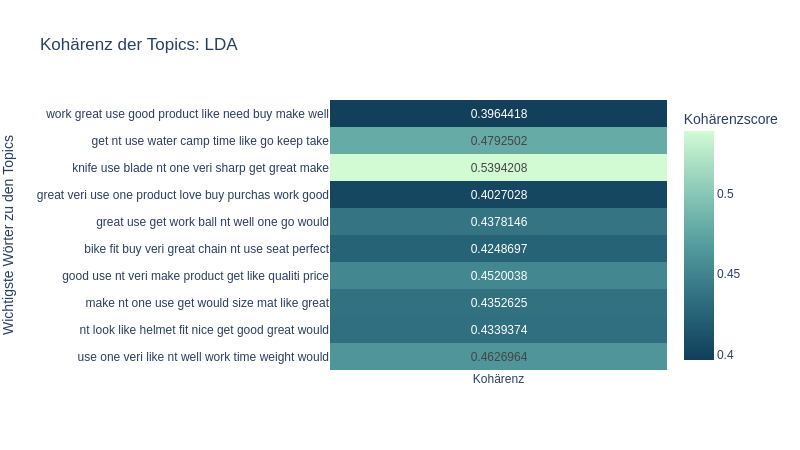

In [ ]:
# Graphische Darstellung
# Darstellung der Themenkohärenz in einer Heatmap
topic_coherence_fig = px.imshow(score_per_topic_df, text_auto=True, aspect="auto", color_continuous_scale=px.colors.sequential.Darkmint_r, title = "Kohärenz der Topics: LDA",
                                labels = dict(color = "Kohärenzscore", y = "Wichtigste Wörter zu den Topics"), height = 600, width = 700)

# Speichern in einem HTML File
topic_coherence_fig.write_html("LDA_Coherence.html")

# Ausgabe
gitly.show(topic_coherence_fig)

#### __Ermittlung der idealen Anzahl von Themen__

Für das Maschine Learning Model LDA muss die gewünschte
Anzahl von Topics im Vorhinein eingegeben. Mithilfe des Kohärenzscore ist es möglich die ideale Anzahl der Topics zu ermitteln. Hierfür wird eine Funktion definiert, in welcher die Modellierung, sowie die Ermittlung des aggregierten Kohärenz Scores für die gewünschte Range von möglichem Topic – Anzahlen iteriert wird. Die Anzahl von Topics, welche den höchsten Kohärenzscore ergeben, bildet den optimalen Parameter für das Modell (Kapadia, 2019)

In [ ]:
# Definition einer Funktion, um die Kohärenzwerte mit unterschiedlichen Anzahlen von Topics zu ermitteln
# Quelle: https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
def compute_coherence_values(dictionary, corpus, docs, limit, start=2, step=2):

    # Erstellen einer leeren Liste und eines DataFramesfür die zu ermittelnden Kohärenzscores
    coherence_values = []
    topic_amount = range(start, limit, step)
    coherence_df = pd.DataFrame(topic_amount, columns=["Amount_number"])
    coherence_df =  coherence_df.assign(Coherencescore = "")

    # Loop zur durchführung der Topic Modelling Modelle mit unterschiedlichen Anzahlen von Topics
    for num_topics in range(start, limit, step):
        # Initialisierung des Topic Modelling Modells
        model=gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics)

        # Initialisierung des Kohärenzmodells
        coherence_model = CoherenceModel(model=model,
                                         texts=docs,
                                         dictionary=dictionary,
                                         coherence='c_v')

        # Ermittlung des Durchschnittlichen Kohärenzscores
        coherence_values.append(coherence_model.get_coherence())

    # Sammeln der Kohärenzscores in einen DataFrame
    coherence_df["Coherencescore"] = coherence_values

    return coherence_df

In [ ]:
# Anwendung der Funktion zur Ermittlung der Kohärenz scores
# Quelle: https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
# Definition der Variablen
limit=20
start=2
step=1

# Anwenden der Funktion
coherence_df = compute_coherence_values(dictionary = dictionary,
                                        corpus = corpus,
                                        docs = token_list,
                                        start = start, limit = limit, step = step)

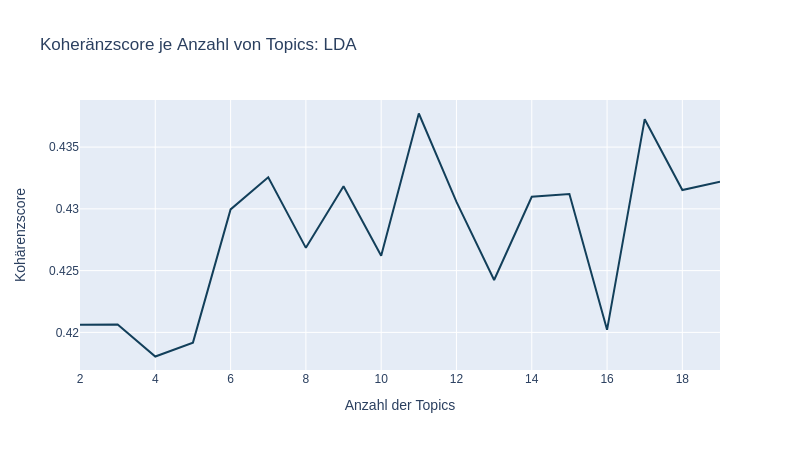

In [ ]:
# Graphische Darstellung
best_coherence_fig = px.line(coherence_df, x="Amount_number", y="Coherencescore", title="Koheränzscore je Anzahl von Topics: LDA",
                      color_discrete_sequence=px.colors.sequential.Darkmint_r)
best_coherence_fig.update_xaxes(title_text= "Anzahl der Topics")
best_coherence_fig.update_yaxes(title_text= "Kohärenzscore")

# Speichern in einem HTML File
best_coherence_fig.write_html("LDA_Best_Coherence.html")

# Ausgabe
gitly.show(best_coherence_fig)

### 5.1.2. Perplexity

Die Perplexity gibt Aufschluss darüber wie gut ein Modell neue Daten verallgemeinern und vorhersagen kann, indem es den Abstand der Themenverteilung des Modells und der gleichmäßigen Wortverteilung des erstellten Wörterbuches misst (Rüdiger, Antons, Joshi, & Salge, 2022). Ein Modell hat ein „gutes Verständnis“ über eine Sprache, wenn es ein semantisch korrektes und häufig auftretendes Wort eine hohe Wahrscheinlichkeit zuweist und einem Seltenem eine niedrige Wahrscheinlichkeit. Aufgrund der umgekehrten Wahrscheinlichkeit, ist eine geringe Perplexity als eine hohe Performence des Modells zu interpretieren (Campagnola, 2020).

In [ ]:
# Perplexity
# Quelle: https://medium.com/analytics-vidhya/topic-modeling-using-gensim-lda-in-python-48eaa2344920
log_perplexity = -1 * lda_model.log_perplexity(corpus)
perplexity = np.exp(log_perplexity)

# Ausgabe
print('Die Perplexity für LDA beträgt: ', perplexity)

Die Perplexity für LDA beträgt:  1997.0058532883456


### 5.1.3. Similarity

Die „Cosine Similarity“ gibt ein Maß für die Ähnlichkeit zweier Vektoren wieder, welche sich in einem mehrdimensionalen Raum befinden. Der Score basiert auf dem Kosinus der Winkelmessung und bezieht sich auf die Orientierung der Vektoren im Raum anstatt auf deren Länge(Sitikhu, Pahi, Thapa, & Shakya, 2019, S. 2).
Das Ergebnis der Kosinusähnlichkeit kann zwischen -1 und 1 liegen. Wenn ein Winkel zwischen zwei Vektoren klein ist, tendiert der Kosinus des Winkels gegen eins, was sich als ein hohes Maß an Ähnlichkeit interpretieren lässt. Je größer der Winkel wird, desto unähnlicher sind sich die Dokumente. Bei 90° und einem Kosinus Wert um null spricht man von orthogonalen Vektoren. Nimmt Kosinus den Wert -1 an, so nähert sich deren Winkel 180° und die Reviews bzw. Wörter sind mit einem gegenteiligen Inhalt zu interpretieren (Supe, 2023).

Befor die Similarity Scores berechnet werden können, müssen die Daten noch in das passende Format transformiert werden:

In [ ]:
# Identifikation der dominante Topic eines Reviews
# Quelle: https://stackoverflow.com/questions/43357247/get-document-topics-and-get-term-topics-in-gensim
# Erstellen einer leeren Liste
topic_list = []

# Identifikation der dominaten Topics
for string in reviews_df.cleanedText:
    # Definiton der Vektoren und selektion der Vektor IDs
    vector = dictionary.doc2bow(string.split())
    clean_vector = [item[0] for item in vector]

    # Extraktion des dominanten Topics
    topics = lda_model.get_document_topics(vector)
    dominant_topic = max(topics, key=lambda x: x[1])[0]

    # Anfügen an die Liste
    topic_list.append({"Vector": clean_vector, "Topic": dominant_topic})

# Umwandeln in einen DataFrame
documents_df = pd.DataFrame(topic_list)

In [ ]:
# Vereinheitlichen der Vektoren
# Länge der Vektoren pro Review bestimmen
documents_df["Vector_Length"] = documents_df.Vector.apply(lambda x: len(x))

# Funktion definieren, um Vektoren zu vereinheitlichen
def fill_with_zeros(review):
  # Vektor und Fehlende Werte bestimmen
  review_max_len = documents_df["Vector_Length"].max()
  modified_vector = review.Vector
  missins_values = review_max_len - len(review.Vector)

  # Falls der Vektor nicht lang genug ist
  if missins_values > 0:
    # Vektor mit Nullen auffüllen und ausgeben
    for i in range(missins_values):
      modified_vector.append(0)
    return modified_vector

  # Falls der Vektor lang genug ist
  else:
    # Vektor unverändert zurückgeben
    return review.Vector

# Anwenden der Funktion zur Vereinheitlichung
documents_df["Vector"] = documents_df.apply(fill_with_zeros, axis=1)

In [ ]:
# Gruppieren der Reviews pro Topic
# Erstellen einer leeren Liste für die Vectoren
vector_dict = {}

# Extrahieren der Topics
topics_unique = np.sort(documents_df.Topic.unique())

# Befüllen des Dictionaries mit den Vectoren pro Topic
for topic in topics_unique:
  vector_dict[str(topic)] = documents_df.loc[documents_df["Topic"] == topic].Vector.tolist()

####__Similarity zwischen den Reviews eines Topics__

Um zu identifizieren, ob sich die Reviews innerhalb eines Topics ähndeln und somit auf einen gleichen Inhalt geschlussfolgert werden kann, wird im folgeden der Similarity Score zwischen den Reviews innerhalt eines Topics berechnent.
Je weiter die Werte gegen 1 tendieren, desto ähnlicher sind die Reviews, welche diesem Topic zugeordnet wurden (Supe, 2023).

In [ ]:
# Similarity Scores pro Topic
# Quelle: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html
# Erstellen eines DataFrames
similarity_df = pd.DataFrame(topics_unique, columns=["Topic_number"])
similarity_df["Similarity"] = ""

# Schleife zur Errechnung des Similarity Scores pro Topic
for key in vector_dict:
  similarity = cosine_similarity(vector_dict[key]).mean()
  similarity_df.loc[similarity_df["Topic_number"] == int(key), "Similarity"] = similarity

# Konvertierung der Spalten in das richtige Datenformat
similarity_df["Topic_number"] = similarity_df["Topic_number"].astype(str)
similarity_df["Similarity"] = similarity_df["Similarity"].astype(float)

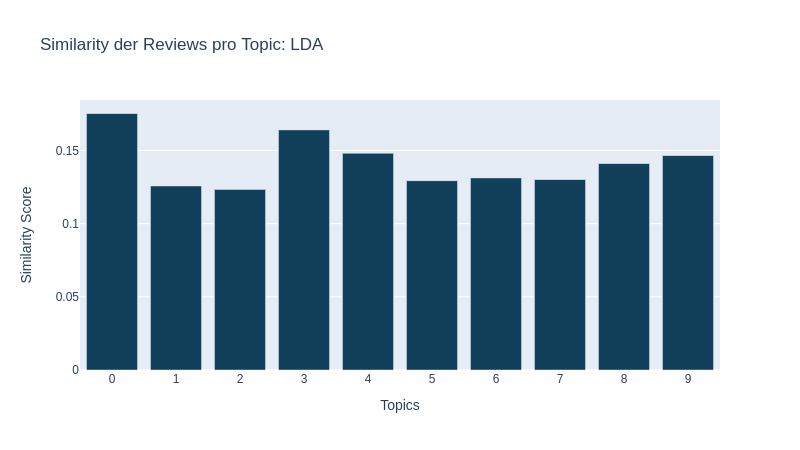

In [ ]:
# Graphische Darstellung
similarity_fig = px.bar(similarity_df, x="Topic_number", y="Similarity", title="Similarity der Reviews pro Topic: LDA",
                        color_discrete_sequence=px.colors.sequential.Darkmint_r)

# Update Layout
similarity_fig.update_xaxes(title_text= "Topics")
similarity_fig.update_yaxes(title_text= "Similarity Score")

# Speichern in ein HTML File
similarity_fig.write_html("LDA_Similarity_per_Topic.html")

# Ausgabe
gitly.show(similarity_fig)

####__Topic Similarity Matrix__

Mithilfe der Topic Similarity Matrix lassen sich ähnliche Topics identifizieren, welche sich mit ähnlichen Inhalten befassen. Die Abbildung wurde in Anlehnung an die "Topic Similarity Matrix" von BERTopic erstellt. Für die Ermittlung des Cosine Similarity Scores werden die Vektoren der Topics miteinander verglichen (Grootendorst, Heatmap, 2023). Die Diagonale bildet den Similarity Score des Topics ab, welches bereits im Schritt zuvor berechnet wurde. Aus diesem Grund ergibt die Diagonale nicht "1" für "identische Vektoren", sondern die Ähnlichkeit der Reviews innerhalb eines Topics.

In [ ]:
# Erstellen der Topic Similarity Matrix
# Erstellen einer leeren Matrix
matrix_for_heat_map = np.zeros((10,10))

# Transformation des NumPy arrays zu einer Liste für schnelleren Loop
topics_unique = list(topics_unique)

# Loop über die Spalten und Zeilen zur Befüllung der Matrix
for col in range(len(topics_unique)):
  for row in range(len(topics_unique)):
    # Errechnung des durchschnittlichen Simiarity Scores
    similarity_between_topics = cosine_similarity(vector_dict[str(topics_unique[col])],
                                                  vector_dict[str(topics_unique[row])]).mean()
    # Hinzufügen des Scores in die Matrix
    matrix_for_heat_map[row,col] = similarity_between_topics

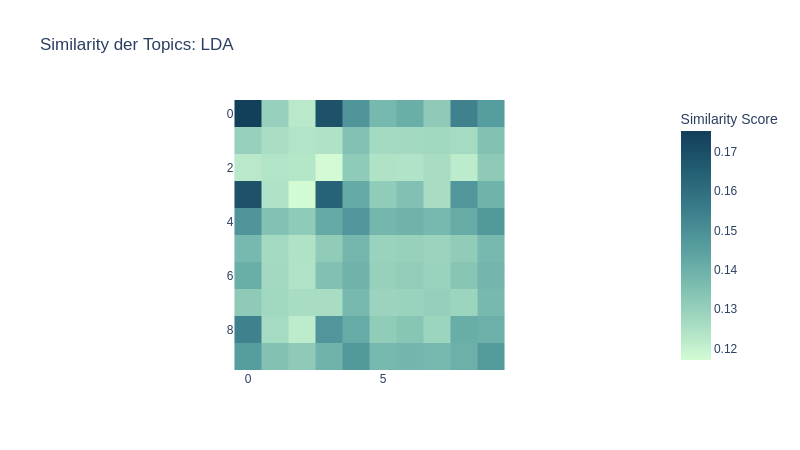

In [ ]:
# Graphische Darstellung
similarity_topics_fig = px.imshow(matrix_for_heat_map, title="Similarity der Topics: LDA",
                                  labels=dict(color="Similarity Score"),
                                  width= 600,
                                  color_continuous_scale=px.colors.sequential.Darkmint)

# Speichern in ein HTML File
similarity_topics_fig.write_html("LDA_Similarity_between_Topic.html")

# Ausgabe
gitly.show(similarity_topics_fig)

#### __Intertopic Distanz der Topics__

Mithilfe der Intertopic Distanz Map lässt sich die Entfernung zwischen den Themen messen. Je ähnlicher sich die Themen sind, desto näher liegen diese beieinander und können sich sogar überlappen, falls diese teilweise identische Inhalte aufweisen. Je weiter die Blasen in dem Diagramm voneinander entfernt sind, desto mehr unterscheiden sich die Themen voneinander. Die Größe der Kreise repräsentieren die Anzahl der im Topic enthaltenen Reviews (Amy, 2022). LDA hat diese Darstellung bereits über die Library LDAvis standardmäßig implementiert (Mageshwaran, 2019).

In [ ]:
# Anzeigen der Intertopic Distanz Map
visualization_lda

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.041507  0.062656       1        1  12.008211
5     -0.044436 -0.043223       2        1  11.925217
1      0.091734 -0.045179       3        1  10.823330
4      0.025506  0.000670       4        1  10.670903
9     -0.004137 -0.020543       5        1  10.516914
6     -0.032060  0.001903       6        1   9.943466
7      0.012285 -0.060533       7        1   9.515805
3      0.083213  0.067596       8        1   9.134861
8     -0.066968 -0.017728       9        1   8.528083
0     -0.023629  0.054383      10        1   6.933211, topic_info=         Term          Freq         Total Category  logprob  loglift
2915    knife  12953.000000  12953.000000  Default  30.0000  30.0000
695      bike  10106.000000  10106.000000  Default  29.0000  29.0000
2909    blade   4845.000000   4845.000000  Default  28.0000  28.0000
145     great  29228.000000  29228.000000  Default  27.0000  27.0000
205   product  12362.000000  12362.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
29        get    953.908981  26874.168808  Topic10  -5.2184  -0.6695
162      love    800.881734  10511.041917  Topic10  -5.3933   0.0944
510       fit    826.149965  13099.433344  Topic10  -5.3622  -0.0947
13         nt    933.983054  33343.883723  Topic10  -5.2395  -0.9063
185       one    879.290774  25282.278249  Topic10  -5.2999  -0.6899

[918 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
2010      1  0.009622     ab
2010      2  0.005773     ab
2010      3  0.005773     ab
2010      4  0.075050     ab
2010      5  0.719708     ab
...     ...       ...    ...
1524      8  0.005989   yoga
1524      9  0.006845   yoga
1524     10  0.023957   yoga
5566     10  0.962239  yummi
3858      8  0.967640  zipti

[3688 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 2, 5, 10, 7, 8, 4, 9, 1])

## 6. Literaturverzeichnis

Andrade, F. (13. 03 2021). 5 Simple Ways to Tokenize Text in Python. Abgerufen am 24. 07 2023 von towardsdatascience.com: https://towardsdatascience.com/5-simple-ways-to-tokenize-text-in-python-92c6804edfc4#33a2

Amy. (21. 10 2022). Topic Modeling with Deep Learning Using Python BERTopic. Abgerufen am 05. 08 2023 von medium.com: https://medium.com/grabngoinfo/topic-modeling-with-deep-learning-using-python-bertopic-cf91f5676504

Campagnola, C. (18. 05 2020). Perplexity in Language Models. Abgerufen am 24. 07 2023 von towardsdatascience.com: https://towardsdatascience.com/perplexity-in-language-models-87a196019a94

CR, A. (26. 07 2020). Topic Modeling using Gensim-LDA in Python. Abgerufen am 20. 06 2023 von medium.com: https://medium.com/analytics-vidhya/topic-modeling-using-gensim-lda-in-python-48eaa2344920

Gensim-Dokumentation. (2016). gensim.utils.simple_preprocess(). Abgerufen am 20. 06 2023 von tedboy.github.io: https://tedboy.github.io/nlps/generated/generated/gensim.utils.simple_preprocess.html

Gensim-Dokumentation. (2023). radimrehurek.com. Abgerufen am 21. 06 2023 von models.ldamulticore – parallelized Latent Dirichlet Allocation: https://radimrehurek.com/gensim/models/ldamulticore.html

Grootendorst, M. (2023). Heatmap. Abgerufen am 07. 08 2023 von maartengr.github.io: https://maartengr.github.io/BERTopic/api/plotting/heatmap.html#bertopic.plotting._heatmap.visualize_heatmap

Kapadia, S. (19. 08 2019). Evaluate Topic Models: Latent Dirichlet Allocation (LDA). Abgerufen am 21. 06 2023 von towardsdatascience.com: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

Mageshwaran, R. (26. 12 2019). Topic Modeling: Art of Storytelling in NLP. Abgerufen am 03. 08 2023 von medium.com: https://medium.com/technovators/topic-modeling-art-of-storytelling-in-nlp-4dc83e96a987

Pascual, F. (26. 09 2019). Topic Modeling: An Introduction. Abgerufen am 13. 12 2022 von monkeylearn.com: https://monkeylearn.com/blog/introduction-to-topic-modeling/

Pedro, J. (10. 01 2022). Understanding Topic Coherence Measures. Abgerufen am 23. 06 2023 von towardsdatascience.com: https://towardsdatascience.com/understanding-topic-coherence-measures-4aa41339634c

Rüdiger, M., Antons, D., Joshi, A. M., & Salge, T.-O. (28. 04 2022). Topic modeling revisited: New evidence on algorithm performance and quality metrics. Abgerufen am 13. 06 2023 von journals.plos.org: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0266325

Sitikhu, P., Pahi, K., Thapa, P., & Shakya, S. (31. 10 2019). A Comparison of Semantic Similarity Methods for Maximum Human Interpretability. Abgerufen am 05. 08 2023 von Department of Electronics and Computer Engineering, Tribhuwan University: https://arxiv.org/pdf/1910.09129.pdf

Supe, K. (07. 06 2023). Understanding Cosine Similarity in Python with Scikit-Learn. Abgerufen am 05. 08 2023 von memgraph.com/: https://memgraph.com/blog/cosine-similarity-python-scikit-learn